# Homework 2

## FINM 37400 - 2025

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from dateutil.relativedelta import relativedelta
import statsmodels.api as sm
from scipy.optimize import minimize

***

# 1 HBS Case: Fixed-Income Arbitrage in a Financial Crisis (A): US Treasuries in November 2008

## Data
* Use the data file `treasury_ts_2015-08-15.xlsx`.
* Examine the treasure issues with `kytreasno` of `204046` and `204047`. These are the bond and note (respectively) which mature on 2015-08-15.
* Look at the data on 2008-11-04.

## 1.1 The situation

Make a chart comparing the issues in the following features, (as of Nov 4, 2008.)
* coupon rate
* bid
* ask
* accrued interest
* dirty price
* duration (quoted in years, not days, assuming 365.25 days per year.)
* modified duration
* YTM

## 1.2 Hedge Ratio

Suppose you are building a trade to go long $n_i$ bonds (`204046`) and short $n_j$ notes (`204047`).

We can find an equation for $n_j$ in terms of $n_i$ such that the total holdings will have duration equal to zero. (Having zero duration also means have zero dollar duration, if helpful.)

Notation:
* $n_i$: number of bonds purchased (or sold)
* $D_i$: duration of bond $i$
* $D_{\$,i}$: dollar duration of bond $i$, equal to $p_iD_i$

If we want the total duration of our holdings to be zero, then we need to size the trade such that $n_i$ and $n_j$ satisfy,

$$0 = n_iD_{\$,i} + n_jD_{\$,j}$$

$$n_j = -n_i\frac{D_{\$,i}}{D_{\$,j}}$$

Suppose you will use \\$1mm of capital, leveraged 50x to buy \\$50mm of the bonds (`204046`).

Use the ratio above to short a number of notes (`204047`) to keep zero duration.

Report the number of bonds and notes of your position, along with the total dollars in the short position.

In [40]:
path1 = '../data/treasury_ts_2015-08-15.xlsx'

data = pd.read_excel(path1, sheet_name='database')
data.set_index('kytreasno', inplace = True)
data.head()


,kycrspid,caldt,tdbid,tdask,tdnomprc,tdnomprc_flg,tdsourcr,tdaccint,tdretnua,tdyld,tdduratn,tdpubout,tdtotout,tdpdint,tdidxratio,tdidxratio_flg
kytreasno,,,,,,,,,,,,,,,,
204046,2.015082e+07,1989-05-02,116.06250,116.31250,116.18750,M,R,2.230663,0.005823,0.000241,3662.963463,6470.0,7150.0,0.0,NaN,NaN
204046,2.015082e+07,1989-05-03,116.18750,116.43750,116.31250,M,R,2.260014,0.001303,0.000241,3664.503530,6470.0,7150.0,0.0,NaN,NaN
204046,2.015082e+07,1989-05-04,115.59375,115.84375,115.71875,M,R,2.289365,-0.004760,0.000242,3651.504100,6470.0,7150.0,0.0,NaN,NaN
204046,2.015082e+07,1989-05-05,116.21875,116.46875,116.34375,M,R,2.318715,0.005545,0.000241,3663.165673,6470.0,7150.0,0.0,NaN,NaN
204046,2.015082e+07,1989-05-08,115.71875,115.96875,115.84375,M,R,2.406768,-0.003472,0.000242,3650.099891,6470.0,7150.0,0.0,NaN,NaN


In [41]:
bond = data.loc[204046]
bond = bond.drop(columns=['tdnomprc_flg','tdsourcr','tdidxratio','tdidxratio_flg'])
bond.columns = ['kycrspid','date','bid','ask','price','accrued interest','tdretnua','ytm','duration','tdpubout','tdtotout', 'interest payment']
bond.set_index('date',inplace=True)
bond = bond.sort_index()
#bond = bond[bond['ytm'] > 0]
bond = bond[bond.index >= '2008-11-04']

bond['dirty'] = bond['price'] + bond['accrued interest']
bond['ytm (annual)'] = (1+bond['ytm'])**365 - 1

display(bond)

,kycrspid,bid,ask,price,accrued interest,tdretnua,ytm,duration,tdpubout,tdtotout,interest payment,dirty,ytm (annual)
date,,,,,,,,,,,,,
2008-11-04,2.015082e+07,141.859375,141.890625,141.875000,2.338655,0.009720,0.000098,1910.307862,2852.0,4024.0,0.0,144.213655,0.036372
2008-11-05,2.015082e+07,142.093750,142.125000,142.109375,2.367527,0.001825,0.000097,1909.874219,2852.0,4024.0,0.0,144.476902,0.036031
2008-11-06,2.015082e+07,142.203125,142.234375,142.218750,2.396399,0.000957,0.000097,1909.156180,2852.0,4024.0,0.0,144.615149,0.035860
2008-11-07,2.015082e+07,141.328125,141.359375,141.343750,2.425272,-0.005851,0.000100,1906.195263,2852.0,4024.0,0.0,143.769022,0.037043
2008-11-10,2.015082e+07,141.750000,141.781250,141.765625,2.511889,0.003537,0.000098,1904.260256,2852.0,4024.0,0.0,144.277514,0.036401
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-10,2.015082e+07,100.101562,100.125000,100.113281,5.165746,0.000540,0.000064,5.000000,3806.0,4024.0,0.0,105.279027,0.023477
2015-08-11,2.015082e+07,100.085938,100.093750,100.089844,5.195097,0.000056,0.000065,4.000000,3806.0,4024.0,0.0,105.284940,0.024169
2015-08-12,2.015082e+07,100.046875,100.078125,100.062500,5.224448,0.000019,0.000081,3.000000,3806.0,4024.0,0.0,105.286948,0.029963


In [42]:
note = data.loc[204047]
note = note.drop(columns=['tdnomprc_flg','tdsourcr','tdidxratio','tdidxratio_flg'])
note.columns = ['kycrspid','date','bid','ask','price','accrued interest','tdretnua','ytm','duration','tdpubout','tdtotout', 'interest payment']
note.set_index('date',inplace=True)
note = note.sort_index()
#note = note[note['ytm'] > 0]
note = note[note.index >= '2008-11-04']

note['dirty'] = note['price'] + note['accrued interest']
note['ytm (annual)'] = (1+note['ytm'])**365 - 1


display(note)

,kycrspid,bid,ask,price,accrued interest,tdretnua,ytm,duration,tdpubout,tdtotout,interest payment,dirty,ytm (annual)
date,,,,,,,,,,,,,
2008-11-04,2.015082e+07,105.953125,105.984375,105.968750,0.935462,0.011642,8.860326e-05,2168.016569,20998.0,32470.0,0.0,106.904212,0.032867
2008-11-05,2.015082e+07,106.046875,106.078125,106.062500,0.947011,0.000985,8.818986e-05,2167.189736,20998.0,32470.0,0.0,107.009511,0.032712
2008-11-06,2.015082e+07,106.234375,106.265625,106.250000,0.958560,0.001860,8.737273e-05,2166.531738,20998.0,32470.0,0.0,107.208560,0.032404
2008-11-07,2.015082e+07,105.718750,105.750000,105.734375,0.970109,-0.004702,8.958989e-05,2164.602920,20998.0,32470.0,0.0,106.704484,0.033239
2008-11-10,2.015082e+07,106.218750,106.250000,106.234375,1.004755,0.005011,8.740250e-05,2162.519284,20998.0,32470.0,0.0,107.239130,0.032415
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-10,2.015082e+07,100.031250,100.054688,100.042969,2.066298,0.000192,3.081345e-05,5.000000,31400.0,32470.0,0.0,102.109267,0.011310
2015-08-11,2.015082e+07,100.031250,100.039062,100.035156,2.078039,0.000038,2.890027e-05,4.000000,31400.0,32470.0,0.0,102.113195,0.010604
2015-08-12,2.015082e+07,100.015625,100.023438,100.019531,2.089779,-0.000038,5.121485e-05,3.000000,31400.0,32470.0,0.0,102.109310,0.018869


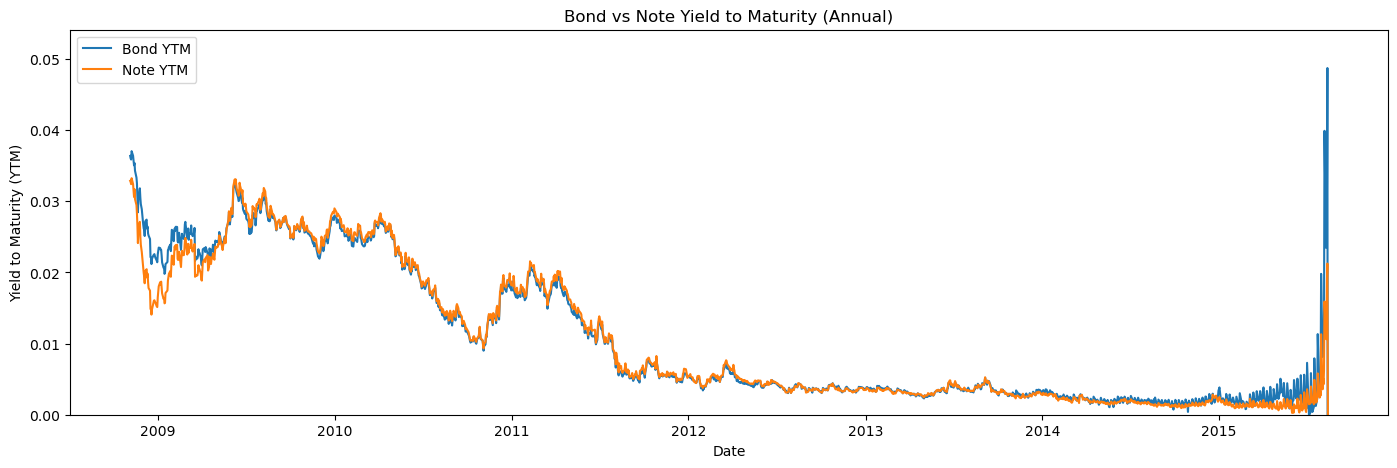

In [43]:
#YTM
plt.figure(figsize=(17,5))
plt.plot(bond['ytm (annual)'], label='Bond YTM')
plt.plot(note['ytm (annual)'], label = 'Note YTM')
plt.title('Bond vs Note Yield to Maturity (Annual)')
plt.xlabel('Date')
plt.ylim(0)
plt.ylabel('Yield to Maturity (YTM)')
plt.legend()
plt.show()

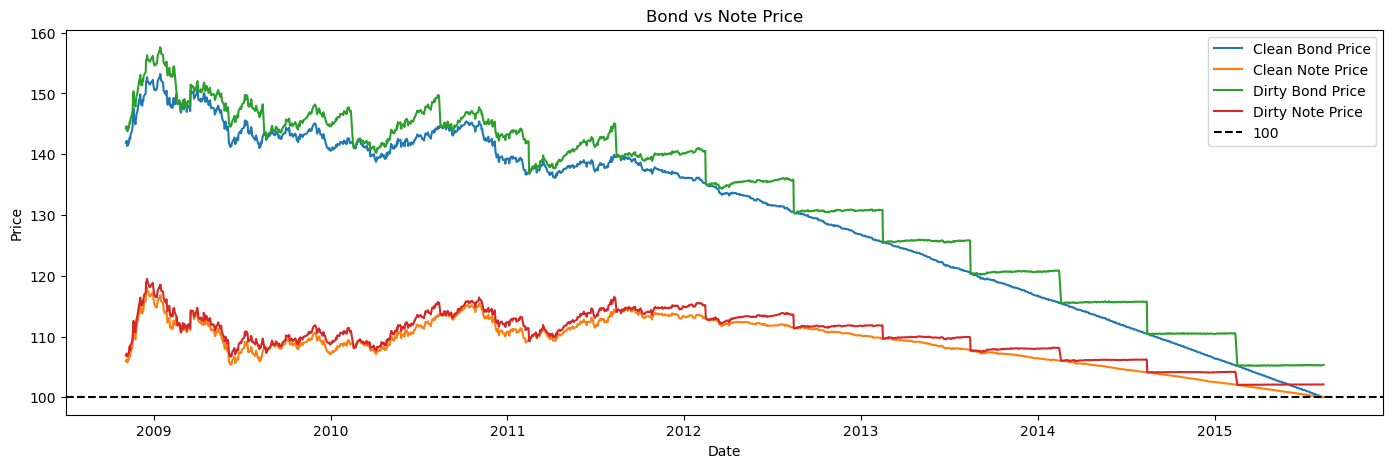

In [44]:
#Price
plt.figure(figsize=(17,5))
plt.plot(bond['price'], label='Clean Bond Price')
plt.plot(note['price'], label = 'Clean Note Price')
plt.plot(bond['dirty'], label='Dirty Bond Price')
plt.plot(note['dirty'], label = 'Dirty Note Price')
plt.title('Bond vs Note Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.axhline(y=100, label= '100', linestyle= '--', color ='black')
plt.legend()
plt.show()

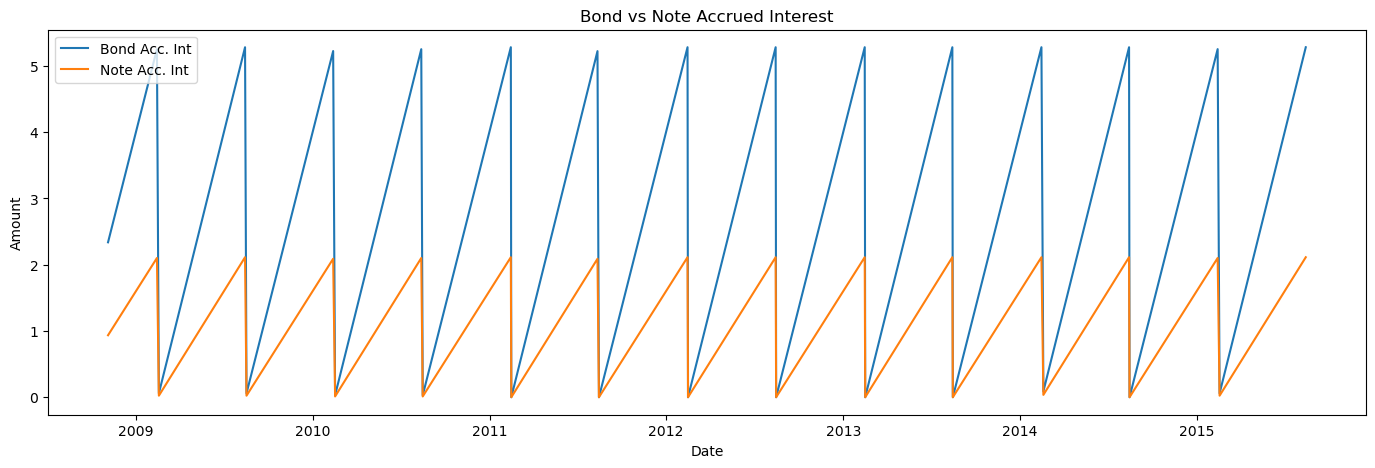

In [45]:
#Accrued Interest
plt.figure(figsize=(17,5))
plt.plot(bond['accrued interest'], label='Bond Acc. Int')
plt.plot(note['accrued interest'], label = 'Note Acc. Int')
plt.title('Bond vs Note Accrued Interest')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.legend()
plt.show()

In [47]:
bond_cpn = bond[bond['interest payment'] > 0].iloc[0]['interest payment']
note_cpn = note[note['interest payment'] > 0].iloc[0]['interest payment']

In [49]:
bond_cpn = bond_cpn / 50
note_cpn = note_cpn / 50

In [53]:
bond['dollar duration'] = bond['duration']*bond['price']
note['dollar duration'] = note['duration']*note['price']

In [54]:
capital = 1000000
buying_power = capital * 50

# Get the number of bonds to purchase
number_of_bonds = buying_power / bond['price'].iloc[0]

# Calculate the number of notes to short to keep zero duration
number_of_notes = -1 * number_of_bonds * (bond['dollar duration'].iloc[0] / note['dollar duration'].iloc[0])

# Calculate the short position dollar amount
short_amount = number_of_notes * note['price'].iloc[0]

#Net Cost of trade
net_cost = buying_power + short_amount

print(f'We are long {number_of_bonds:.2f} bonds, and short {number_of_notes:.2f} notes, with short $ amount of {short_amount:.2f}')
print(f'The net cost of the trade is {net_cost: .2f}')

We are long 352422.91 bonds, and short -415750.67 notes, with short $ amount of -44056578.93
The net cost of the trade is  5943421.07


## 1.3 Profit Opportunity

Using the concept of **modified duration**, how much profit or loss (PnL) would you expect to make for every basis point of convergence in the spread? Specifically, assume the convergence is symmetric: the bond's (`204046`) ytm goes down 0.5bp and the note (`204047`) ytm goes up 0.5bp.

Describe the PnL you would expect to achieve on your position should this happen. Specify the PnL of the long position, the short position, and the net total.

Suppose the spread in YTM between the two securities disappears, due to a symmetric move of roughly ~17bps in each security's YTM. What is the PnL? (This is just a linearly scaling of your prior answer for a 1bp convergence.) 


## 1.4 Result in 2008

Calculate the profit (or loss) on the position on the following two dates:
* 2008-11-25
* 2008-12-16

To calculate the pnl on each date, simply use the prices of the securities on those dates along with your position sizes, ($n_i, n_j$). No coupon is being paid in November or December, so all you need is the "dirty" price on these two dates.

Does the pnl make sense (approximately) given your results in 1.3 with regard to the sensitivity of pnl to moves in the YTM spread?

## 1.5 Examining the Trade through June 2009

Calculate the pnl of the trade for the following dates:
* 2009-01-27
* 2009-03-24
* 2009-06-16

Did the trade do well or poorly in the first six months of 2009?

Calculate the YTM spreads on these dates. Does the YTM spread correspond to pnl roughly as we would expect based on the calculation in 1.3?

# 1.3 Solution

In [58]:
bond['duration (annual)'] = bond['duration'] / 365.25
bond['mod duration'] = bond['duration (annual)'] / (1 + bond['ytm (annual)'])

note['duration (annual)'] = note['duration'] / 365.25
note['mod duration'] = note['duration (annual)'] / (1 + note['ytm (annual)'])

bond_row = bond.iloc[0]
note_row = note.iloc[0]

bond_pos_change = - bond_row['mod duration'] * buying_power * 0.005
note_pos_change = - note_row['mod duration'] * short_amount * 0.005

pos_change = bond_pos_change + note_pos_change

print(f'{pos_change} would be the total with a 1 bp change.')

print(f'{17 * pos_change} would be the total with a 17 bp change.')




4281.29264850053 would be the total with a 1 bp change.
72781.97502450901 would be the total with a 17 bp change.


# 1.4 Solution

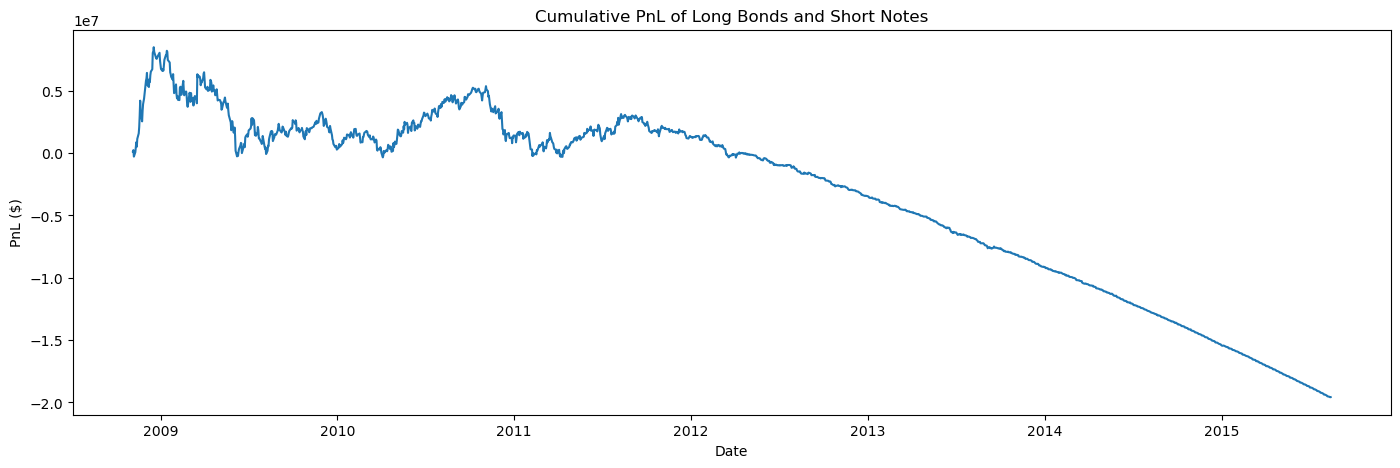

In [59]:
strategy = pd.DataFrame(index=bond.index)

# Calculate percentage price change
strategy['bond price return'] = bond['price'].pct_change()
strategy['note price return'] = note['price'].pct_change()

# Calculate PnL for long bonds
strategy['pnl bonds'] = strategy['bond price return'] * number_of_bonds * bond['price'].iloc[0]

# Calculate PnL for short notes
strategy['pnl notes'] = -strategy['note price return'] * number_of_notes * note['price'].iloc[0]

# Total PnL (long bond PnL + short note PnL)
strategy['pnl'] = (strategy['pnl bonds'] + strategy['pnl notes']).cumsum()
strategy = strategy.dropna()

plt.figure(figsize=(17,5))
plt.plot(strategy['pnl'])
plt.title('Cumulative PnL of Long Bonds and Short Notes')
plt.xlabel('Date')
plt.ylabel('PnL ($)')
plt.show()



# 1.5 Solution

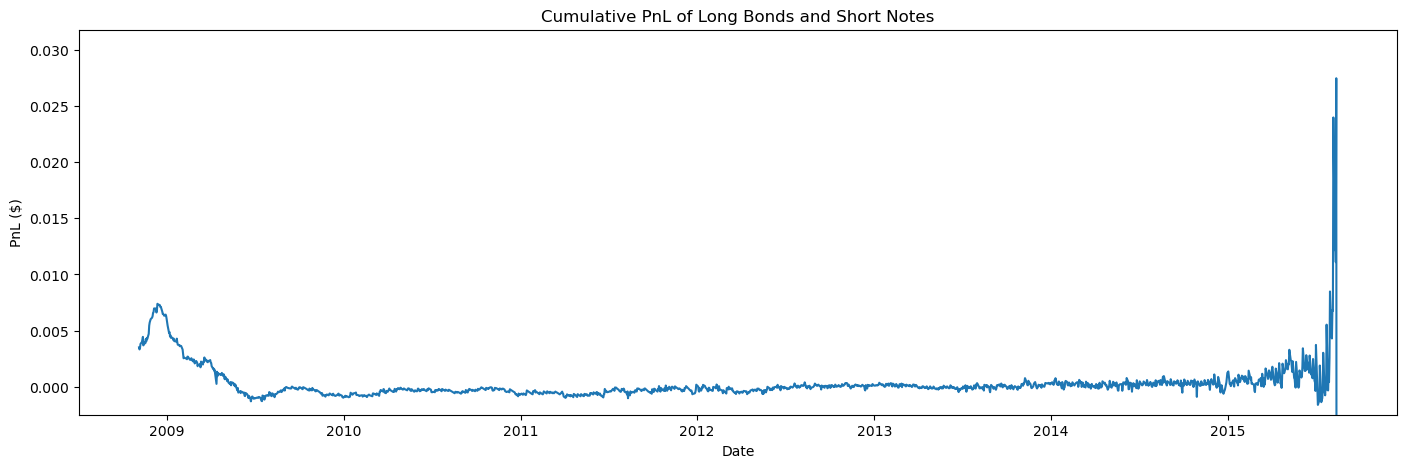

In [60]:
ytm_spread = bond['ytm (annual)'] - note['ytm (annual)']


plt.figure(figsize=(17,5))
plt.plot(ytm_spread)
plt.title('Cumulative PnL of Long Bonds and Short Notes')
plt.xlabel('Date')
plt.ylim(-0.0025)
plt.ylabel('PnL ($)')
plt.show()


***

# 2 Hedging Duration

Use data from `../data/treasury_ts_duration_2024-10-31.xlsx`.

The file contains time-series information on two treasuries. Observe the info of the securities with the following code:


In [61]:
import pandas as pd

In [62]:
QUOTE_DATE = '2024-10-31'
filepath = f'../data/treasury_ts_duration_{QUOTE_DATE}.xlsx'

data = pd.read_excel(filepath,sheet_name='database')
data_info =  data.drop_duplicates(subset='KYTREASNO', keep='first').set_index('KYTREASNO')
data_info[['type','issue date','maturity date','cpn rate']]

,type,issue date,maturity date,cpn rate
KYTREASNO,,,,
207391,note,2019-08-15,2029-08-15,1.625
207392,bond,2019-08-15,2049-08-15,2.250


You will largely focus on the sheets which give the timeseries of prices and durations for each of the two securities, as shown in the following code.

In [63]:
SHEET_PRICE = 'price'
SHEET_DURATION = 'duration'
INDEX_NAME = 'quote date'

price = pd.read_excel(filepath,sheet_name=SHEET_PRICE).set_index(INDEX_NAME)
duration = pd.read_excel(filepath,sheet_name=SHEET_DURATION).set_index(INDEX_NAME)

display(price)
display(duration)

,207391,207392
quote date,,
2019-08-09,98.882812,99.789062
2019-08-12,99.796875,102.554688
2019-08-13,99.281250,101.867188
2019-08-14,100.406250,105.179688
2019-08-15,100.882812,106.234375
...,...,...
2024-11-22,88.740234,63.722656
2024-11-25,89.287109,65.378906
2024-11-26,89.214844,65.175781


,207391,207392
quote date,,
2019-08-09,9.289497,22.000102
2019-08-12,9.285468,22.118496
2019-08-13,9.280314,22.084308
2019-08-14,9.282750,22.228549
2019-08-15,9.282163,22.270910
...,...,...
2024-11-22,4.539445,17.205511
2024-11-25,4.531983,17.312267
2024-11-26,4.529132,17.295472


### 2.1.

Suppose you have a portfolio of `10,000` USD long in security `207391` on the first day of the sample.

If you want to manage interest rate exposure using duration, how large of a short position should you hold in `207392`?

### 2.2.

Step through the time-series, doing the following:

* Starting at the end of the first day, set the hedged position according to the relative given durations.
* Use the second day's price data to evaluate the net profit or loss of the hedged position.
* Reset the the hedged position using the end-of-second-day durations. Again fix the long position of security `207391` to be `10,000`.
* Repeat throughout the timeseries.

Calculate the daily profit and loss (PnL) for the
* dynamically hedged position constructed above.
* long-only position, (still at `10,000` throughout.)

(You might check to verify that the net duration is zero at all dates.)

Report...
* the cumulative PnL of both strategies via a plot.
* the (daily) mean, standard deviation, min, and max of the PnL in a table.

### 2.3.

Give two reasons that the daily PnL is not always zero for the hedged position given that we have perfectly hedged the duration.

### 2.4.
The PnL above doesn't account for the coupons.

Calculate a dataframe indexed by dates with columns for the two treasuries with values of coupon payments. 
* Recall that the stated coupon rate is semiannual, so at any give coupon date, it pays half the stated rate.
* Figure out the coupon dates by using the `data` tab and looking for dates where `acc int` goes down. Recall that accrued interest measures the portion of the coupon period that has passed. So when this resets, it is because the coupon has been paid.

Report the first 5 dates that a coupon is paid (by either bond).

### 2.5.
Account for the coupons in the PnL calculations of `2.2`. Report the updated PnL in a plot and a table, similar to the reporting in `2.2`.

***

In [66]:
price1 = price[207391]
price2 = price[207392]

duration1 = duration[207391]
duration2 = duration[207392]

dollarduration1 = price1*duration1
dollarduration2 = price2*duration2

In [67]:
buying_power = 10000

#Intial bond holdings
bond1_holdings = buying_power / price1.iloc[0]

#Short holdings to offset intrest rate risk

bond2_holdings = -bond1_holdings*(dollarduration1.iloc[0] / dollarduration2.iloc[0])

short_size = bond2_holdings*price2.iloc[0]

print(f'We will short {bond2_holdings: .2f} units of bond 2 with a value of {short_size: .2f}$')

We will short -42.31 units of bond 2 with a value of -4222.48$


# 2.2 Solution

In [68]:
strategy = pd.DataFrame(index = price.index)

strategy['bond 1 holdings'] = bond1_holdings
strategy['bond 1 notional($)'] = bond1_holdings*price1
strategy['bond 1 $ duration'] = dollarduration1
strategy['bond 2 $ duration'] = dollarduration2
strategy['Hedge holdings'] = -bond1_holdings*(dollarduration1/dollarduration2)
strategy['Hedge notional($)'] = strategy['Hedge holdings']*price2
strategy['Net Duration'] = strategy['bond 1 notional($)']*duration1 + strategy['Hedge notional($)']*duration2
strategy['bond 1 return'] = strategy['bond 1 notional($)'].pct_change()
strategy['bond 1 cuml return'] = (1+strategy['bond 1 return']).cumprod() -1
strategy['Hedge return'] = (strategy['Hedge holdings']*price2.shift()).pct_change()
strategy['Hedge cuml return'] = (1+strategy['Hedge return']).cumprod() -1
strategy['strat return'] = strategy['bond 1 return'] - strategy['Hedge return']
strategy['strat cuml return'] = (1+strategy['strat return']).cumprod() -1

In [69]:
strategy

,bond 1 holdings,bond 1 notional($),bond 1 $ duration,bond 2 $ duration,Hedge holdings,Hedge notional($),Net Duration,bond 1 return,bond 1 cuml return,Hedge return,Hedge cuml return,strat return,strat cuml return
quote date,,,,,,,,,,,,,
2019-08-09,101.12981,10000.000000,918.571597,2195.369559,-42.314047,-4222.479083,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-12,101.12981,10092.438967,926.660707,2268.355459,-41.313199,-4236.862229,-1.455192e-11,0.009244,0.009244,NaN,NaN,NaN,NaN
2019-08-13,101.12981,10040.293909,921.361181,2249.666318,-41.418178,-4219.153341,1.455192e-11,-0.005167,0.004029,0.030326,0.030326,-0.035493,-0.035493
2019-08-14,101.12981,10154.064944,932.046140,2337.991880,-40.315644,-4240.386855,0.000000e+00,0.011331,0.015406,-0.033145,-0.003824,0.044476,0.007405
2019-08-15,101.12981,10202.259619,936.410749,2365.936174,-40.026034,-4252.140661,-1.455192e-11,0.004746,0.020226,0.025101,0.021181,-0.020354,-0.013100
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-22,101.12981,8974.283003,402.831437,1096.380838,-37.157040,-2367.745278,0.000000e+00,-0.000132,-0.102572,-0.003932,-0.426389,0.003800,0.047508
2024-11-25,101.12981,9029.588368,404.647659,1131.857048,-36.154690,-2363.754089,0.000000e+00,0.006163,-0.097041,-0.025752,-0.441161,0.031914,0.080939
2024-11-26,101.12981,9022.280161,404.065821,1127.245916,-36.250386,-2362.647224,0.000000e+00,-0.000809,-0.097772,0.028707,-0.425118,-0.029517,0.049033


Text(0, 0.5, 'Date')

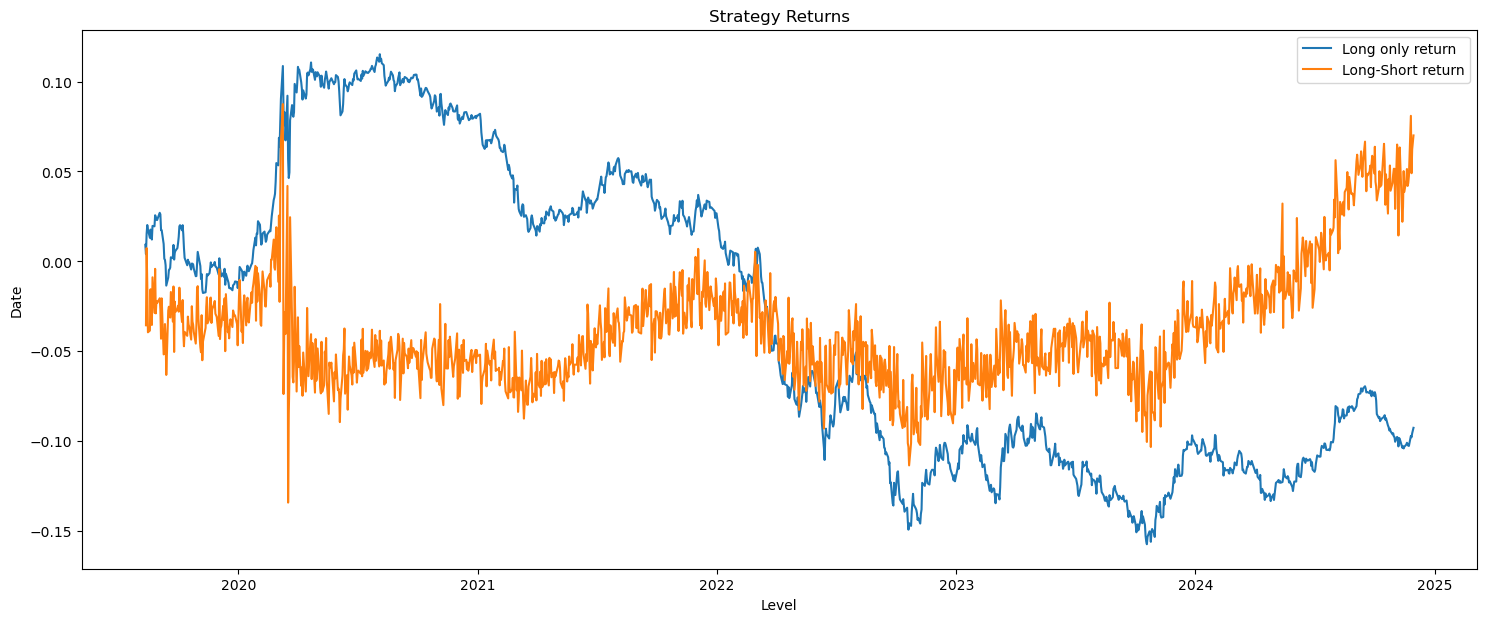

In [70]:
plt.figure(figsize=(18,7))
plt.plot(strategy['bond 1 cuml return'], label = 'Long only return')
plt.plot(strategy['strat cuml return'], label = 'Long-Short return')
plt.legend()
plt.title('Strategy Returns')
plt.xlabel('Level')
plt.ylabel('Date')

# 2.3 Solution

1. Duration hedges are measuring the sensitivity to a parallel shift in the yield curve. If there is a flattening or steepening (a change in shape), different duration bonds would have different moves based upon the yield curve that is not proportional to the durations.

2. Bonds 207391 and 207392 are fundamentally different bonds. Trading them may have different liquidity and potential mispricings as well as a whole different group of buyers/sellers. As a result, it would be hasty to assume that the sampled price of these 2 bonds shift in lock-step.

# 2.4 Solution

In [72]:
bond1cpn = data[data['KYTREASNO'] == 207391]['cpn rate']
bond2cpn = data[data['KYTREASNO'] == 207392]['cpn rate']